# Light_Capture Code
### Author: Pegah S. Mirabedini, Code last modified on Feb, 2020

The following code provides a a Monte Carlo-based ray-tracing model that simulates light interactions at the surface of micropillars in a microfluidic reactor. The reactors are developed by our experimentalist collaborators, Dr. Rao and hist team, for treating recycled water on spacecraft during deep space missions. The LightCapture code provides an efficient tool to predict geometry–light interaction correlations in any reactor consisting of micropillars and can readily be generalized to study other more complex geometries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math  

In [2]:
def get_random_direction_angles():
    """ Helper function one: Generate random angles Theta and Phi
       Theta is in range (-pi,pi)
       Phi is in range (0,pi/2)"""
    Theta2 = (np.random.rand()-0.5)*2*np.pi  
    phi2 = np.arccos(1-np.random.rand())    
    return Theta2, phi2   

In [3]:
def normal(v):
    """Helper function two: find normal of a vector"""
    n_v = v/np.sqrt(v[0]**2+ v[1]**2+v[2]**2)
    return n_v

In [4]:
def rel_dir_cartesian(normalV,V2, Theta2, phi2): 
    """Helper function three: Find the angles of a vector with respect to a new coordinate."""
    #take a polar angle defined relative to normal vector and convert them to the angles in cartesian
    v2 = [np.sin(phi2)*np.cos(Theta2),np.sin(phi2)*np.sin(Theta2),np.cos(phi2)]
    #define the new coordinate system:
    x_nc = V2
    z_nc = normal(normalV)
    y_nc = np.cross(z_nc,x_nc)
                
    #v2 direction in the cartesian coordinates:
    v2_cart = np.multiply(v2[0],x_nc) + np.multiply(v2[1],y_nc) + np.multiply(v2[2],z_nc)
    v2_mag = np.sqrt(v2_cart[0]**2+v2_cart[1]**2+v2_cart[2]**2)
                
    #find the angles in cartesian and call them Theta3 and phi3:
    Theta3 = np.arctan2(v2_cart[1],v2_cart[0])
    phi3 =  np.arccos(v2_cart[2])
    return Theta3, phi3

In [5]:
def HitsPillarQ(x,y,z,phi,Theta,pil_height,L,R):
    """Main function one
       input: coordinate and angles of the incoming ray, reactor's setup (pil_height: - height of pillar,
       L: pitch distance, R: pillar's radius)
       output: whether a light ray (phonon path) hits the pillar, or the ground, or 
       any of the walls of the imaginary simulation box, distance travelled, final position and angles."""
    m = np.tan(Theta)
    Theta = ((Theta+np.pi) % (2*np.pi)) - np.pi   
    Theta_A = np.arctan2((R-y),-x)
    Theta_B = np.arctan2(-y,(R-x))
    global d
    global sc
    global X_nopil,Y_nopil, Z_nopil
    
    X_nopil, Y_nopil, Z_nopil= 0, 0, 0 
    X_nogr, Y_nogr, Z_nogr= 0, 0, 0

    Hit_ground = [0,0,0]
    Hit_pil = [0,0,0]

    
    if Theta_B >0:
        Theta_A = Theta_A -2*np.pi
        Theta_B = Theta_B -2*np.pi
    Theta_C = np.arctan2(-y,(L-x))
    Theta_D = np.arctan2((L-y),(L-x))
    Theta_E = np.arctan2((L-y),-x)
        
    if Theta_A >0:
        Theta_A = Theta_A-2*np.pi
            
    if Theta_A < Theta < Theta_B:
        Ct = np.cos(Theta)
        St = np.sin(Theta)
        Ct2 = Ct*Ct
        St2 = St*St
        X = -(y*Ct*St) + (x*St2) + np.sqrt(Ct2*((R-y)*(R+y)*Ct2 + (R-x)*(R+x)*St2 + x*y*np.sin(2*Theta)))
        Y = np.sqrt(R**2-X**2)
        wall = 5
        Theta_n = np.arctan2(Y,X)
        d = np.sqrt((X-x)**2 + (Y-y)**2)  
        Z = d/np.tan(phi)
        Hit_pil = [X,Y,Z]
        #if there was no pillar:
        X_nopil = x - (pil_height-z)*(x-X)/(Z-z) #this is the same as when having a ground 
        Y_nopil = y - (pil_height-z)*(y-Y)/(Z-z)
        Z_nopil = pil_height
                    
    elif Theta_B < Theta < Theta_C:
        Xa = x-y/m
        X = Xa
        Y = 0
        wall = 1
        Theta_n = np.pi/2
                
    elif Theta_C < Theta < Theta_D:
        Yb = y+m*(L-x)
        X = L
        Y = Yb
        wall = 2
        Theta_n = np.pi

    elif Theta_D < Theta < Theta_E:  
        Xc = x+(L-y)/m
        X = Xc
        Y = L
        wall = 3
        Theta_n = -np.pi/2
            
    else:
        Yd = y-x*m
        X = 0
        Y = Yd
        wall = 4
        Theta_n = 0.0
        
    d = np.sqrt((X-x)**2 + (Y-y)**2)  
    Z = d/np.tan(phi)
    v = np.sqrt((X-x)**2+(Y-y)**2+(Z-z)**2) 
    phi_new = phi
    Theta_new = 2*Theta_n - np.pi - Theta
    sc = 1
    
    #ground
    if Z <= pil_height:
        #if there was no ground:
        X_nogr, Y_nogr, Z_nogr = X, Y, Z
        wall = 6
        #if there is ground
        X = x - ((pil_height-z)*(x-X))/(Z-z)
        Y = y - ((pil_height-z)*(y-Y))/(Z-z)
        Z = pil_height
        Hit_ground = [X, Y, Z]
        Theta_new = Theta
        phi_new = np.pi - phi

        
    if Z > 0:
        wall = 7
        X = x - z*(x-X)/(z-Z)
        Y = y - z*(y-Y)/(z-Z)
        Z = 0
        Theta_new = Theta
        phi_new = np.pi - phi
        
    HitPoint = [X,Y,Z]
    Hitpoint_nopil = [X_nopil,Y_nopil,Z_nopil]
    Hitpoint_nogr = [X_nogr,Y_nogr,Z_nogr]
    
    
    #for a ray that hits the pillar consider some specularity:
    s = 0 #specularity coefficient (an empirical value)
        
    if 5<=wall<7:
        if np.random.random() < s: 
            sc = 0
            #print('specular reflection')
        else: 
            sc = 1
            #print('diffuse reflection')
            
            #choose random angles for reflection
            Theta2,phi2 = get_random_direction_angles()
            
            if wall == 5:
                #print('diffuse wall 5')
                Z = [HitPoint[0],HitPoint[1],0.0] 
                X = [0,0,1]
            else:
                Z = [0,0,1]
                X = [1,0,0]
                    
            Hitpoint_n = normal(HitPoint)    
            Theta_new,phi_new = rel_dir_cartesian(Z,X,Theta2,phi2) 
     
    
    return([wall,d,v,HitPoint[0],HitPoint[1],HitPoint[2],Theta_new,phi_new,sc,Hit_pil[0],Hit_pil[1],Hit_pil[2],
            Hit_ground[0],Hit_ground[1],Hit_ground[2],Hitpoint_nopil[0], Hitpoint_nopil[1],Hitpoint_nopil[2],
            Hitpoint_nogr[0],Hitpoint_nogr[1],Hitpoint_nogr[2]])   

In [52]:
def FollowRay(Lambda,Pil_height,L,R):
    """ Main function two: follow a light ray from a random initial position for many times until it either: get 
        absorbed by the pillar or ground, or leaves from the top surface. If the ray is not absorbed after 
        that many times, assume that it is lost.
        inputs: absoption factor, reactor's setup (pil_height: - height of pillar, L: pitch distance, 
        R: pillar's radius
        Output: final status and position of the ray after many iterations and reflection type."""
    
    x_hit = []
    y_hit = []
    z_hit = []
    RES = []
    r = 0
    z = 0
    
    #define a random ray direction and angles:
    while r<R:        
        x = np.random.random()*L
        y = np.random.random()*L
        r = np.sqrt(x**2+y**2)
       
    Th,phi = get_random_direction_angles()
    phi = np.pi-phi
    
    
    # initial parameters:
    global N_absorbed_pillar
    global N_absorbed_Ground
    global N_absorbed_water
    global N_lost
    global N_lost_top
    global N_diffuse
    global N_specular
    N_absorbed_pillar=0
    N_absorbed_Ground = 0
    N_absorbed_water = 0
    N_lost = 0
    N_lost_top = 0
    N_diffuse = 0
    N_specular = 0
    leg = 0
    Ref = 0.2
    keep = 0
    leg_max = 1000
    
    
    #main loop: follow a ray for leg_max times:
    while leg < leg_max: 
        leg+=1
        #find HitsPillarQ
        HP = HitsPillarQ(x,y,z,phi,Th,Pil_height,L,R)
        [wall,d,v,x,y,z,Th,phi,sc,xp,yp,zp,xg,yg,zg,x_nop,y_nop,z_nop,x_nog,y_nog,z_nog] = HP
        
        # if the ray hits somewhere below the surface
        if wall<7:
            # check if the ray was absorbed by water
            Cw = np.exp(-v/Lambda)
            if np.random.random() > Cw:
                #print('absorbed by water')
                RES = [2,x,y,z,Th,phi,sc,xp,yp,zp,xg,yg,zg,x_nop,y_nop,z_nop,x_nog,y_nog,z_nog]
                N_absorbed_water+=1
                
            # The ray is not absorbed by water, then it will hit something! 
            # check if the ray hits the ground or pillar
            elif wall >= 5:
                if np.random.random() > Ref:
                    if wall == 5:
                        #print('absorbed by pillar')
                        N_absorbed_pillar+=1
                        RES = [1,x,y,z,Th,phi,sc,xp,yp,zp,xg,yg,zg,x_nop,y_nop,z_nop,x_nog,y_nog,z_nog]
                    else:
                        #print('absorbed by ground')
                        N_absorbed_Ground+=1
                        RES = [0,x,y,z,Th,phi,sc,xp,yp,zp,xg,yg,zg,x_nop,y_nop,z_nop,x_nog,y_nog,z_nog]
                    break
                 
                
                #If reflected, check whether the reflection is specular or diffuse
                dice2 = np.random.random()
                if sc==1:
                    N_specular+=1
                    #print('reflected specular')
                else:
                    N_diffuse+=1
                    #print('reflected diffuse')
        
        
        #If the ray ended up somewhere above the surface, it leaves the simulation box.
        elif wall==7: 
            #print('Left from the top surface')
            N_lost_top+=1
            RES = [3,x,y,z,Th,phi,sc,xp,yp,zp,xg,yg,zg,x_nop,y_nop,z_nop,x_nog,y_nog,z_nog]
            break 

     
    # Asuume the ray is lost if it did not get absorbed by leg_max
    else:
        #print('lost because it did not get absorbed after {} iterations.'.format(leg_max))
        N_lost+=1 
        RES = [-1,x,y,z,Th,phi,sc,xp,yp,zp,xg,yg,zg,x_nop,y_nop,z_nop,x_nog,y_nog,z_nog]
            
            
    return (RES,Th*(180/np.pi),phi*(180/np.pi),N_absorbed_pillar,N_absorbed_Ground,N_absorbed_water,
            N_lost,N_lost_top,N_specular,N_diffuse)

In [10]:
#test value for HitsPillarQ: 
if __name__ == "__main__":
    Lambda = 10**8
    pil_h = -100
    L_i = 20
    R_i = 5
    F = FollowRay(Lambda,pil_h,L_i,R_i)
    
    if F[0][0]==5:
        print('The incoming ray hits the pillar.')
    elif F[0][0]==6:
        print('The incoming ray hits the ground.')
    elif F[0][0]==7:
        print('The incoming ray hits the top surface.')
    else:
        print('The incoming ray hits wall {}.'.format(F[0][0]))

    print(F)

The incoming ray hits wall 1.
([1, 1.5450888169220591, 4.755281332142442, -17.620810851662974, 0.42591503752950016, 0.5525996044910074, 1, 1.5450888169220591, 4.755281332142442, -17.620810851662974, 0, 0, 0, -106.98377167420146, -69.6424774330403, -100, 0, 0, 0], 24.403134081596423, 31.661625097933257, 1, 0, 0, 0, 0, 0, 0)


In [11]:
def Ray_Trace(N,Lambda,Pil_height,L,R):
    """Main function Two: perform Ray_Trace for N rays, and obtain an statistical averaging.
       input: N: number of light rays in simulation, absorption factor, 
       reactor's setup (pil_height: - height of pillar, L: pitch distance, R: pillar's radius"""

    N_pil = 0
    N_wat = 0
    N_los = 0
    N_gr = 0
    N_top = 0
    N_spec = 0
    N_dif = 0
    hitpoint = [] #pillar and ground
    hitpoint_nopil = [] #if there was no pillar
    hitpoint_nogr = [] #if there was no ground
    hitpoint_gr = [] #only ground
    hitpoint_pil = [] #only pillar
    hitangle = []
    hitangle_nopil = []
    hitangle_nogr = []
    hitangle_gr = []
    hitangle_pil = []
    
    for i in range(0,N):
        OUT=FollowRay(Lambda,Pil_height,L,R)
        p = list(OUT[0])
        N_spec = N_spec + N_specular
        N_dif = N_dif + N_diffuse
        
        if 0<=p[0]<= 1:
            p = list(OUT[0])
            hitpoint.append(p[1:4])
            #print("hitpoint",hitpoint)
            hitangle.append([np.arctan2(p[1],p[2]),np.arctan2(d,p[3])])
            
            if p[0]==1:
                N_pil+=1
                hitpoint_pil.append(p[7:10])
                hitangle_pil.append([np.arctan2(p[7],p[8]),np.arctan2(d,p[9])])
                hitpoint_nopil.append(p[13:16]) 
                hitangle_nopil.append([np.arctan2(p[13],p[14]),np.arctan2(d,p[15])])
                
            elif p[0]==0:
                N_gr+= 1
                hitpoint_gr.append(p[10:13])
                hitangle_gr.append([np.arctan2(p[10],p[11]),np.arctan2(d,p[12])])
                hitpoint_nogr.append(p[16:19])
                hitangle_nogr.append([np.arctan2(p[16],p[17]),np.arctan2(d,p[18])])
        
        elif p[0] == 2:
            N_wat += 1
            
        elif p[0] == 0:
            N_gr += 1
            
        elif p[0] == 3:
            N_top += 1
        
        else:
            N_los += 1
    i=i+1
    
    P_pil = N_pil/N
    P_gr = N_gr/N
    P_wat = N_wat/N
    P_top = N_top/N
    P_los = N_los/N
    
    return (P_pil,P_gr,P_wat,P_top,P_los,hitpoint,hitpoint_pil,hitpoint_gr,hitpoint_nopil,hitpoint_nogr,
            hitangle,hitangle_pil,hitangle_gr,hitangle_nopil,hitangle_nogr,N_dif,N_spec)

In [15]:
if __name__ == "__main__":
    
    Lambda = 10**8
    N = 1000
    pil_h = -100
    R = 5
    L = 20
    RT = Ray_Trace(N,Lambda,pil_h,L,R)
    Pp,Pg,Pw,Pt,Pl = RT[:5]
    hitpoint,hitpoint_p,hitpoint_gr,hitpoint_nopil,hitpoint_nogr = RT[5:10]
    hitangle,hitangle_p,hitangle_gr,hitangle_nopil,hitangle_nogr,diffuse,specular = RT[10:]
    
    print("{}% of rays were absorbed by pillar". format (Pp*100))
    print("{}% of rays were absorbed by ground".format (Pg*100))
    print("{}% of rays were absorbed by water".format (Pw*100))
    print("{}% of rays left from the top".format (Pt*100))
    print("{}% of rays were lost after runs".format(Pl*100))

85.7% of rays were absorbed by pillar
1.5% of rays were absorbed by ground
0.0% of rays were absorbed by water
12.5% of rays left from the top
0.3% of rays were lost after runs


In [16]:
#making arrays of hitpoints and hitangles for plotting purpose 
Hitpoint = np.array(hitpoint)
Hitangle = np.array(hitangle)
Hitpoint_pil = np.array(hitpoint_p)
Hitangle_pil = np.array(hitangle_p)
Hitpoint_gr = np.array(hitpoint_gr)
Hitangle_gr = np.array(hitangle_gr)
Hitpoint_nopil = np.array(hitpoint_nopil)
Hitangle_nopil = np.array(hitangle_nopil)
Hitpoint_nogr = np.array(hitpoint_nogr)
Hitangle_nogr = np.array(hitangle_nogr)

#theta angles:
Th_h= Hitangle[:,0]
th_pil = Hitangle_pil[:,0]
th_gr = Hitangle_gr[:,0]
th_h_nopil = Hitangle_nopil[:,0]
th_h_nogr = Hitangle_nogr[:,0]
Phi = Hitangle[:,1]  

print("Hitpoint_pil",len(Hitpoint_pil))
print("Hitpoint_gr",len(Hitpoint_gr))
print("Hitpoint_nogr",len(Hitpoint_nogr))
print("Hitpoint_nopil",len(Hitpoint_nopil))

#pillar and ground hit points:
x_h =Hitpoint[:,0]
y_h =Hitpoint[:,1]
z_h =Hitpoint[:,2]

#only pillar (real points)
x_pil = Hitpoint_pil[:,0]
y_pil = Hitpoint_pil[:,1]
z_pil = Hitpoint_pil[:,2]

#only ground (real points)
x_gr = Hitpoint_gr[:,0]
y_gr = Hitpoint_gr[:,1]
z_gr = Hitpoint_gr[:,2]

#if there was no pillar
x_h_nopil = Hitpoint_nopil[:,0]
y_h_nopil = Hitpoint_nopil[:,1]
z_h_nopil = Hitpoint_nopil[:,2]

#confine no pillar to inside the pillar:
x_h_nopil_Conf = []
y_h_nopil_Conf = []
z_h_nopil_Conf = []
Points_nopilConf = []
Theta_nopil = []
R = 5

for i in range(0,len(x_h_nopil)): 
    if np.sqrt(x_h_nopil[i]**2+y_h_nopil[i]**2) <= R:
        x_h_nopil_Conf.append(x_h_nopil[i])
        y_h_nopil_Conf.append(y_h_nopil[i])
        z_h_nopil_Conf.append(z_h_nopil[i])
        nopil = [x_h_nopil[i],y_h_nopil[i],z_h_nopil[i]]
        Points_nopilConf.append(nopil)
        Thetanopil = th_h_nopil[i]
        Theta_nopil.append(Thetanopil)
        


#if there was no ground
x_h_nogr = Hitpoint_nogr[:,0]
y_h_nogr = Hitpoint_nogr[:,1]
z_h_nogr = Hitpoint_nogr[:,2]

#confine no ground to the pillar p:
x_h_nogr_Conf = []
y_h_nogr_Conf = []
z_h_nogr_Conf = []
Points_nogrConf = []
Theta_nogr = []
R = 5

for m in range(0,len(x_h_nogr)):
    if np.sqrt(x_h_nogr[m]**2+y_h_nogr[m]**2)==R:
        x_h_nogr_Conf.append(x_h_nogr[m])
        y_h_nogr_Conf.append(y_h_nogr[m])
        z_h_nogr_Conf.append(z_h_nogr[m])
        nogr = [x_h_nogr[m],y_h_nogr[m],z_h_nogr[m]]
        Points_nogrConf.append(nogr)
        Thetanogr = th_h_nogr[m]
        Theta_nogr.append(Thetanogr)
        

#all hitpoints: 
x = [x_pil,x_gr,x_h_nopil_Conf,x_h_nogr_Conf]
X_all=np.concatenate(x,axis=0)
y = [y_pil,y_gr,y_h_nopil_Conf,y_h_nogr_Conf]
Y_all=np.concatenate(y,axis=0)
z = [z_pil,z_gr,z_h_nopil_Conf,z_h_nogr_Conf]
Z_all=np.concatenate(z,axis=0)



All_Points = []
for x in range(0,len(X_all)):
    point = [X_all[x],Y_all[x],Z_all[x]]
    All_Points.append(point)

    
#all rays hitting pillar:
Z_pil = [z_pil,z_h_nogr_Conf] #hits pillar + if there was no ground and the ray continued until hitting pillar.
Z_pil_all = np.concatenate(Z_pil,axis=0)
Th_pil = [th_pil,Theta_nogr]
Th_pil_all = np.concatenate(Th_pil,axis=0)


#all rays hitting the ground:
X_gr = [x_gr,x_h_nopil_Conf]
X_gr_all = np.concatenate(X_gr,axis=0)
Y_gr = [y_gr,y_h_nopil_Conf]
Y_gr_all = np.concatenate(Y_gr,axis=0)
Z_gr = [z_gr,z_h_nopil_Conf]
Z_gr_all = np.concatenate(Z_gr,axis=0)


th_h_all = [Th_h,Theta_nopil,Theta_nogr]
Theta_all = np.concatenate(th_h_all,axis=0)


#save output txt
#np.savetxt("./All_points.txt", All_Points)

Hitpoint_pil 857
Hitpoint_gr 15
Hitpoint_nogr 15
Hitpoint_nopil 857


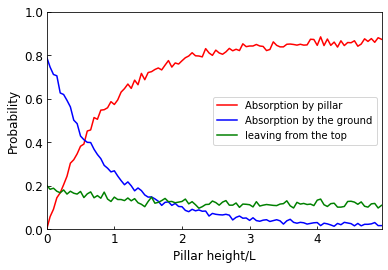

In [18]:
def Probs(h,N,Lambda,pil_h,L,R):
    results = Ray_Trace(N,Lambda,h,L,R)
    P_p,P_g,P_t = results[0],results[1],results[3]
    return P_p,P_g,P_t


def plot_probabilities(N,Lambda,pil_h,L,R):

    W = np.sqrt(2)*L - 2*R
    hp = 0
    P_pil = []
    P_gr = []
    P_top = []
    H = range(0,pil_h)

    HL = []
    for h in H:
        hl = h/L
        HL.append(hl)
        
    for hp in range(0,len(H)):
        hp = hp
        p_pil = Probs(-hp,N,Lambda,pil_h,L,R)[0]
        P_pil.append(p_pil)
        p_gr = Probs(-hp,N,Lambda,pil_h,L,R)[1]
        P_gr.append(p_gr)
        p_top = Probs(-hp,N,Lambda,pil_h,L,R)[2] 
        P_top.append(p_top)
        hp+=1
        
    plt.plot(HL,P_pil,'r',label = 'Absorption by pillar')
    plt.plot(HL,P_gr,'b',label = 'Absorption by the ground')
    plt.plot(HL,P_top,'g',label = 'leaving from the top')
    plt.xlim(0,np.max(HL))
    plt.ylim(0,1)
    plt.xlabel('Pillar height/L',fontsize=12)
    plt.ylabel('Probability',fontsize=12)
    plt.tick_params(direction='in',labelsize=12)
    plt.legend(loc='center right',
              bbox_transform=plt.gcf().transFigure)

    plt.show()

    
if __name__ == "__main__":
    
    Lambda = 10**8
    N = 1000
    pil_h = 100 #use positive value for plotting purpose.
    R = 5
    L = 20
    
    plot_probabilities(N,Lambda,pil_h,L,R)

In [19]:
#Gaussian distribution: 
def G(X,Y,i,j,wx,wy):
    A= 1/(2*np.pi*(wx*wy))
    B= (X-i)/wx
    F= (Y-j)/wy
    J = B**2+F**2
    C= A*np.exp(-J/2)
    return C

In [20]:
#probability distribution:
def P3d(x,y,xo,yo,wx,wy):  
    X,Y = xo, yo
    S=np.zeros(np.shape(X))
    N=len(x)  
    n=0
    
    while n<N:
        i=x[n]
        j=y[n]
        S += G(X,Y,i,j,wx,wy)
        n+=1
    return S/N

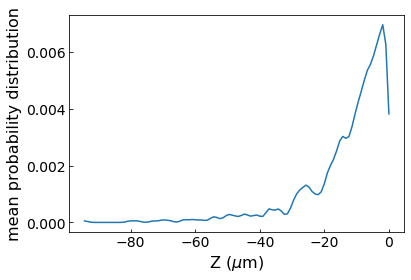

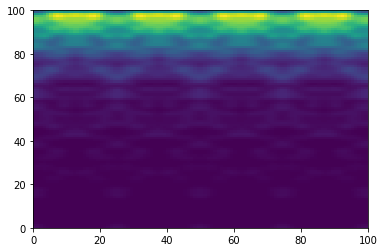

In [21]:
# probability distribution plots for absorption of light on pillar
th = th_pil
z = z_pil
nmap=100

xd = np.concatenate((th,0.5*np.pi-th))
xd = np.concatenate((xd-np.pi*0.5,xd,xd+np.pi*0.5,xd+np.pi,xd+np.pi*1.5,xd+np.pi*2))
yd = np.concatenate((z,z))
yd = np.concatenate((yd,yd,yd,yd,yd,yd))
yo_min = min(yd)
xo = np.linspace(0,2*np.pi,nmap)
yo = np.linspace(yo_min,0,nmap)
xg, yg = np.meshgrid(xo,yo)

p = P3d(xd,yd,xg,yg,np.pi*2/50.0,1)

#plot probability distribution of light absorption vs. distance from pillar's surface (depth)
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(yo,p.mean(1))
ax2.set_ylabel('mean probability distribution',fontsize=16)
ax2.set_xlabel('Z ($\mu$m)',fontsize=16)
ax2.tick_params(direction='in',labelsize=14)
plt.show()

#Surface plot of probability distribution of light absorption on the pillar
fig3=plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
ax3.pcolormesh(p)
plt.show()

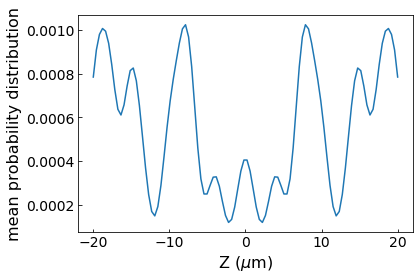

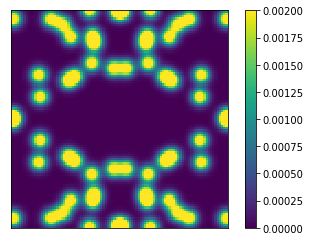

In [22]:
# probability distribution plots for absorption of light on ground
xgr = x_gr
ygr = y_gr
nmap=100

xd = np.concatenate((xgr,-xgr,xgr,-xgr))
yd = np.concatenate((ygr,ygr,-ygr,-ygr))
xo = np.linspace(-L,L,nmap)
yo = np.linspace(-L,L,nmap)
xg, yg = np.meshgrid(xo,yo)

pg = P3d(xd,yd,xg,yg,1,1)


#plot probability distribution on ground vs. box length (=pitch size)
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(yo,pg.mean(1))
ax2.set_ylabel('mean probability distribution',fontsize=16)
ax2.set_xlabel('Z ($\mu$m)',fontsize=16)
ax2.tick_params(direction='in')
plt.tick_params(labelsize=14)
plt.show()


#Surface plot of probability distribution of light absorption on the ground
fig3=plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
cmap = ax3.pcolormesh(xo, yo, pg, vmin=0, vmax=0.002)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_aspect(1)
fig3.colorbar(cmap,ax=ax3)
plt.show()

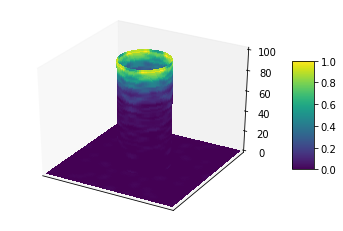

In [23]:
# 3D plot of light absorption on pillar and ground.
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker, cm
from matplotlib.patches import Circle, PathPatch
from matplotlib.transforms import Affine2D
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#for pillar
z = np.linspace(0, pil_h,100)
theta = np.linspace(-np.pi,np.pi,100)
theta_grid, z_grid=np.meshgrid(theta, z)
x_grid = 7.5*np.cos(theta_grid) 
y_grid = 7.5*np.sin(theta_grid) 
Xc,Yc,Zc = x_grid,y_grid,z_grid


#for ground
x = np.linspace(-L,L,100)
y = np.linspace(-L,L,100)
x_grid2, y_grid2=np.meshgrid(x,y)
z_grid2 = 0*x_grid2
Xg,Yg,Zg = x_grid2,y_grid2,z_grid2


# plot setup 
p2 = np.copy(p)
pg2 = np.copy(pg)
p2 *= Pp/sum(sum(p2))
pg2 *= Pg/sum(sum(pg2))
pp= np.concatenate([p2,pg2],axis=0)
my_c = cm.viridis(pp/np.max(pp))
my_col = my_c[0:100]
my_colgr = my_c[100:200]


# surface plot
surf = ax.plot_surface(Xc, Yc, Zc, rstride=1, cstride=1, facecolors = my_col,
        linewidth=0, antialiased=False,shade=False,vmin = 0, vmax = 0.5)

surf = ax.plot_surface(Xg, Yg, Zg, rstride=1, cstride=1, facecolors = my_colgr,
        linewidth=0, antialiased=False,shade=False,vmin = 0, vmax = 0.5)


# Add a color bar which maps values to colors.
fig.colorbar(surf,shrink=0.5, aspect=5,)
ax.grid(None)
plt.xticks([])
plt.yticks([])
plt.xlim(-L,L)
plt.ylim(-L,L)
plt.show()

In [24]:
#Define Gaussian and P:
def G2(X,i,wx):
    A = 1/(wx*np.sqrt(2*np.pi))
    B = (X-i)/wx
    J = B**2
    C = A*np.exp(-J/2)
    return C

def P2D(x,xo,wx):
    print('xo',np.shape(xo))
    X = xo
    S = np.zeros(np.shape(X))
    N = len(x)
    n = 0
    
    while n<N:
        i = x[n]
        S += G2(X,i,wx)
        n += 1
    return S/N

In [93]:
def Test_R(N,Lambda,pil_h,L,RV):
    fig=plt.figure()
    ax=plt.subplot(111)
    nmap=100
    R=RV
    color = ['xkcd:purple','C1','C2','C3','b','k']
    

    for i in range(0,len(R)):
        t=R[i]
        RT = Ray_Trace(N,Lambda,-pil_h,L,t)
        p1,p2,p3 = RT[:3]
        points,angels = RT[5],RT[10]
        xd = np.array(angels)[:,0]
        yd = np.array(points)[:,2]
        yo_min = -pil_h
        xo = np.linspace(0,2*np.pi,nmap)
        yo = np.linspace(yo_min,0.0,nmap)
        xg, yg = np.meshgrid(xo,yo)
        p = P3d(xd,yd,xg,yg,0.2,0.2)
        p=p.mean(1)

        Area_water = 4*L**2-np.pi*t**2
        Area_pillar = 2*np.pi*t*pil_h
        Ip_over_Iin = (Area_water/Area_pillar)*p
        
        string="r= "+str(t)
        ax.plot(yo,Ip_over_Iin,label=string)
        ax.set_ylabel('Relative intensity ($I_p/I_{in}$)',fontsize=14)
        #ax.set_ylabel('Mean Probability distribution',fontsize=14)
        ax.set_xlabel('z ($\u03BC$m)',fontsize=14)
        ax.set_ylim(0,0.007)
        ax.set_xlim(yo_min,0)
        ax.tick_params(direction='in')
        plt.tick_params(labelsize=12)
    
    plt.legend()
    plt.show()    

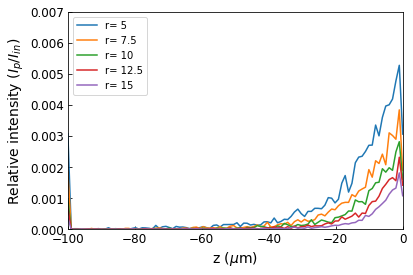

In [94]:
if __name__ == "__main__":
    
    Lambda = 10**8
    N = 5000
    pil_h = 100
    L = 20
    RV = [5,7.5,10,12.5,15]
    
    Test_R(N,Lambda,pil_h,L,RV)